# Introduction
RFM (Recency, Frequency, Monetary) analysis is a well-established technique designed for behaviour-driven customer segmentation. Specifically, RFM analysis evaluates customers' recency (how long ago they made a purchase), frequency (how often they make purchases), and monetary value (how much money they spend).

RFM helps divide customers into various segments to identify those more likely to respond to promotions.

In this notebook, we will perform RFM segmentation and compare the results with those obtained using the K-means clustering algorithm on the same data.


# Table of Contents
- Data Import
- Data Exploration and Cleaning
    - Checking null values
    - Duplicate values
    - Cleaning records with zero UnitPrice
    - Removing cancelled purchases
- RFM Analysis
    - RFM Framework
    - Calculating Recency, Frequency and Monetary Values
    - Exploratory Analysis of RFM Features
        - Distributions
        - Correlations
        - Box Plots
    - Assigning RFM Scores
    - RFM Segmentation
    - Analysis of Segments
- K-Means Clustering
    - Log Transformation
    - Standardising Data
    - Elbow Method
    - Silhouette Score
    - Model with 4 Clusters
    - Evaluating Clusters
        - Recency and Frequency by Cluster
        - Recency and Monetary by Cluster
- Comparing Results: RFM Segments vs. K-Mean Clusters
    - Descriptive Statistics
    - Mapping of Clusters and RFM Segments
- Conclusion
    - Example of marketing strategies for RFM segments
- References

# Data Import
This dataset contains 8 variables that correspond to:

<b> InvoiceNo </b>: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  
<b> StockCode </b> : Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.  
<b> Description </b>: Product (item) name. Nominal.  
<b> Quantity </b>: The quantities of each product (item) per transaction. Numeric.  
<b> InvoiceDate </b>: Invoice date and time.  
<b> UnitPrice </b>: Unit price. Numeric, Product price per unit in sterling.  
<b> CustomerID </b>: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.  
<b> Country </b>: Country name. Nominal, the name of the country where each customer resides.

In [1]:
#Importing necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('data.csv', 
                   encoding = 'unicode_escape',
                   parse_dates = ['InvoiceDate'],
                   dtype={'CustomerID': str,'InvoiceNo': str})
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


# Data Exploration and Cleaning
## Checking Null Values

In [4]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

There are about 135K records without a CustomerID. Our goal is to segment the customers. So, CustomerID is crucial for segmentation. Let's drop the rows where CustomerID is null.

In [5]:
data.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
data.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Duplicate Values

In [6]:
print('Number of duplicates: {}'.format(data.duplicated().sum()))


Number of duplicates: 5225


In [7]:
data.drop_duplicates(inplace = True)

In [8]:
print('Number of duplicates: {}'.format(data.duplicated().sum()))

Number of duplicates: 0


The data has no duplicate values now.

## Cleaning Records with Zero UnitPrice

In [9]:
data[data['UnitPrice']==0].describe()

,Quantity,UnitPrice
count,40.000000,40.0
mean,347.100000,0.0
std,1978.311813,0.0
min,1.000000,0.0
25%,1.000000,0.0
50%,4.500000,0.0
75%,24.000000,0.0
max,12540.000000,0.0


There are 40 records that have UnitPrice equal 0. I did not notice any pattern in the records with UnitPrice==0. There were no field indicating discount or promotion.  These records may result to Monetary value equal zero. These records will be removed from the dataset.

In [10]:
data=data[data['UnitPrice']!=0]

The records where UnitPrice equals 0 were removed.

## Removing Cancelled Purchases
If the InvoiceNo starts from a letter 'C' that means that the purchase was cancelled. The values of such purchases should not be included in the monetary value when RFM analysis is performed. There are 8,905 records where InvoiceNo starts from 'C'.

In [11]:
len(data[data['InvoiceNo'].str.startswith('C')])


8872

In [12]:
data = data[~data['InvoiceNo'].str.startswith('C')]


Now the data does not contain cancelled purchases.

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  object        
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.0+ MB


# RFM Analysis

## RFM Framework

There are multiple approaches for RFM segmentation. 
I will use the RFM framework with assignment of scores from 1 to 3 for each (Recency, Frequency, Monetary). Based on the assigned score the below customer segments are defined:

| Segment name | RFM score breakouts | Description |
|------------|--------------------------------------|-------------|
| Champions  | 333, 332, 323                       | The best customers  |
| Loyal      | 321, 322, 331, 232, 233               | Valuable customers that are engaged |
| Recent     | 312, 313, 311, 222, 223               | Recent customers  |
| Needs attention | 213, 221, 123, 132, 133          | A valuable customer that has not purchased recently |
| At risk    | 231, 212, 122, 131, 211               | A customer that has not purchased recently and/or tends to spend less overall |
| Inactive   | 111, 112, 113, 121                   | A lapsed customer  |

## Calculating Recency, Frequency and Monetary Values

<b> Recency </b> is the number of days since the last purchase made by a customer. To calculate Recency, we need calculated how many days passed from the current date to the date of the last purchase. Thus, we need to define the current date. The data contains purchases from 2010 and 2011. The maximum data available in the dataset is 2011-12-09. We take this days to avoid zeros in Recency.  

In [14]:
print(data['InvoiceDate'].max())
current_date = dt.datetime(2024,2,4)

2011-12-09 12:50:00


<b> Frequency </b> shows how often a customer purchases from the company within the report’s time frame. To calculate Frequency, we will calculate number of unique invoices for each CustomerID.

<b> Monetary </b> is the total cost spend on purchases by every customer. Before calculating the Monetary, we need to calculate total cost by multiplying number of UtitPrice and Quantity.

In [15]:
data['TotalCost'] = data['Quantity'] * data['UnitPrice']

In [17]:
rfm = data.groupby("CustomerID").agg({"InvoiceDate" : lambda InvoiceDate :(current_date - InvoiceDate.max()).days,  # Recency
                                     "InvoiceNo" : lambda InvoiceNo: InvoiceNo.nunique(),  # Frequency
                                     "TotalCost":  lambda TotalCost: TotalCost.sum()})    # Monetary
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,4764,1,77183.60
12347,4441,7,4310.00
12348,4514,4,1797.24
12349,4457,1,1757.55
12350,4749,1,334.40


## Exploratory Analysis of RFM Features


In [18]:
rfm.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,4531.059474,4.272015,2048.688081
std,100.012264,7.697998,8985.230220
min,4439.000000,1.000000,3.750000
25%,4456.000000,1.000000,306.482500
50%,4489.000000,2.000000,668.570000
75%,4580.750000,5.000000,1660.597500
max,4812.000000,209.000000,280206.020000


### Distributions

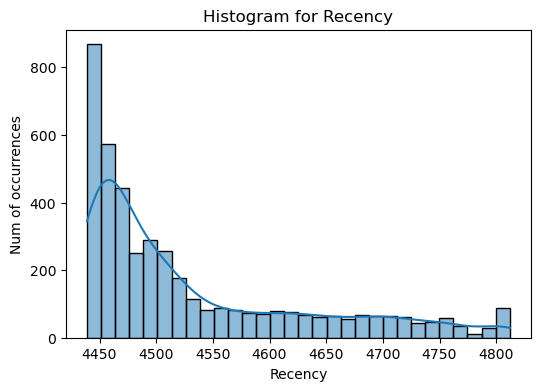

In [19]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=rfm, x='Recency', bins=30, kde=True)
plt.title('Histogram for Recency')
plt.xlabel('Recency')
plt.ylabel('Num of occurrences')
plt.show()

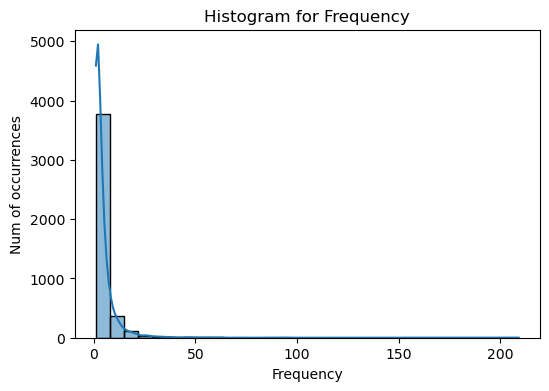

In [20]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=rfm, x='Frequency', bins=30, kde=True)
plt.title('Histogram for Frequency')
plt.xlabel('Frequency')
plt.ylabel('Num of occurrences')
plt.show()

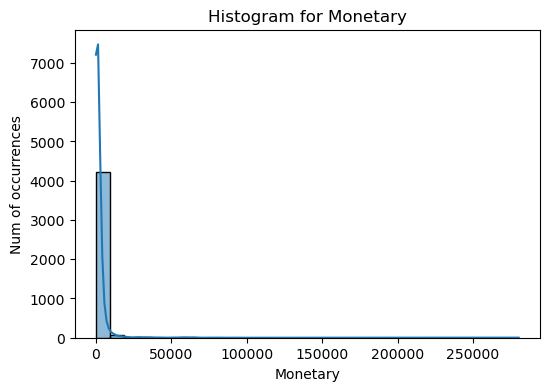

In [21]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=rfm, x='Monetary', bins=30, kde=True)
plt.title('Histogram for Monetary')
plt.xlabel('Monetary')
plt.ylabel('Num of occurrences')
plt.show()

### Correlation

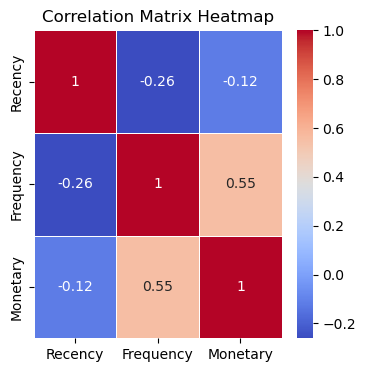

In [22]:
corr_matrix = rfm[['Recency', 'Frequency', 'Monetary']].corr()
plt.figure(figsize=(4,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

There is a moderate correlation between Frequency and Monetary. This correlation is expected, as customers tend to spend more when they make purchases more frequently.

Recency, Frequency, and Monetary features have a lot of outliers. The outliers may make segmentation process more difficult.

## Assigning RFM Scores

There are multiple approaches for RFM segmentation. 
We will use the RFM framework with assignment of scores from 1 to 3 for each (Recency, Frequency, Monetary). 3 is the best/highest value, and 1 is the lowest/worst value. 

A final RFM score is calculated simply by combining individual RFM score numbers.  
The RFM segments will be defined using the below table   

| Segment name | RFM score breakouts | Description |
|------------|--------------------------------------|-------------|
| Champions  | 333, 332, 323                       | The best customers  |
| Loyal      | 321, 322, 331, 232, 233               | Valuable customers that are engaged |
| Recent     | 312, 313, 311, 222, 223               | Recent customers  |
| Needs attention | 213, 221, 123, 132, 133          | A valuable customer that has not purchased recently |
| At risk    | 231, 212, 122, 131, 211               | A customer that has not purchased recently and/or tends to spend less overall |
| Inactive   | 111, 112, 113, 121                   | A lapsed customer  |

In [23]:
rfm["Recency_Score"]  = pd.qcut(rfm['Recency'], 3, [3, 2, 1])
rfm["Frequency_Score"]  = pd.qcut(rfm['Frequency'].rank(method="first"), 3, [1, 2, 3])
rfm["Monetary_Score"]  = pd.qcut(rfm['Monetary'], 3, [1, 2, 3])
rfm["RFM_Score"] = rfm["Recency_Score"].astype(str) + rfm["Frequency_Score"].astype(str) + rfm["Monetary_Score"].astype(str)
rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
CustomerID,,,,,,,
12346,4764,1,77183.60,1,1,3,113
12347,4441,7,4310.00,3,3,3,333
12348,4514,4,1797.24,2,2,3,223
12349,4457,1,1757.55,3,1,3,313
12350,4749,1,334.40,1,1,1,111


## RFM Segmentation


In [24]:
def segment_customers(rfm_score):
    if rfm_score in ['333', '332', '323']:
        return 'Champions'
    elif rfm_score in ['321', '322', '331', '232', '233']:
        return 'Loyal'
    elif rfm_score in ['312', '313', '311', '222', '223']:
        return 'Recent'
    elif rfm_score in ['213', '221', '123', '132', '133']:
        return 'Needs attention'
    elif rfm_score in ['231', '212', '122', '131', '211']:
        return 'At risk'
    elif rfm_score in ['111', '112', '113', '121']:
        return 'Inactive'
    
rfm['Segment'] = rfm['RFM_Score'].apply(segment_customers)
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4338 entries, 12346 to 18287
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Recency          4338 non-null   int64   
 1   Frequency        4338 non-null   int64   
 2   Monetary         4338 non-null   float64 
 3   Recency_Score    4338 non-null   category
 4   Frequency_Score  4338 non-null   category
 5   Monetary_Score   4338 non-null   category
 6   RFM_Score        4338 non-null   object  
 7   Segment          4338 non-null   object  
dtypes: category(3), float64(1), int64(2), object(2)
memory usage: 345.5+ KB


In [25]:
rfm.reset_index(inplace=True)
rfm.groupby('Segment').agg({'CustomerID':'count'})

,CustomerID
Segment,
At risk,703
Champions,960
Inactive,974
Loyal,778
Needs attention,334
Recent,589


## Analysis of Segments

### Statistical characteristics of the segments

In [27]:
rfm_stats = rfm[['Recency','Frequency','Monetary','Segment']].groupby('Segment').agg({'mean','std','max','min'})

rfm_stats


Recency                               Frequency       \
                    min   max         mean        std       min  max   
Segment                                                                
At risk            4465  4797  4541.526316  73.130287         1    6   
Champions          4439  4464  4449.181250   7.439885         2  209   
Inactive           4531  4812  4674.309035  79.987216         1    4   
Loyal              4439  4530  4471.061697  22.433228         1   63   
Needs attention    4465  4811  4554.874251  70.417304         1   34   
Recent             4439  4530  4480.879457  23.791914         1    4   

                                      Monetary                          \
                      mean        std      min        max         mean   
Segment                                                                  
At risk           1.547653   0.816631     6.20    1149.02   467.986132   
Champions        10.706250  13.920943   400.86  280206.02  5998.648469   
Inactive          1.163244   0.436095     3.75   77183.60   397.662012   
Loyal             4.703085   3.614359    49.80   80850.84  1743.005040   
Needs attention   3.461078   2.636652     6.90   44534.30  1599.673566   
Recent            2.067912   0.866304    30.00   12601.83   885.976946   

                               
                          std  
Segment                        
At risk            278.915871  
Champions        17978.933169  
Inactive          2487.674255  
Loyal             3433.932571  
Needs attention   3459.751153  
Recent            1014.815794

### Number of Customers per Segment

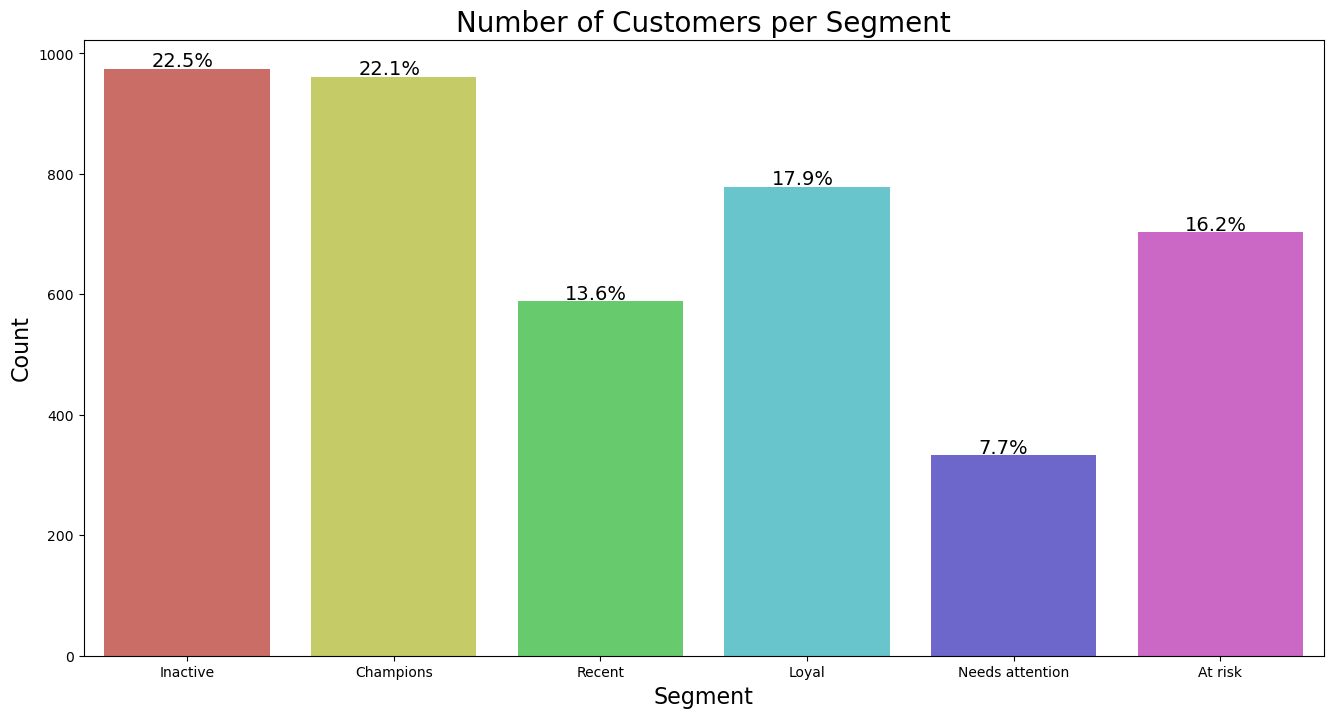

In [28]:
plt.figure(figsize = (16, 8))
ax = sns.countplot(data = rfm,
                   x = 'Segment',
                   palette = 'hls')
total = len(rfm.Segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 14)
plt.title('Number of Customers per Segment', size = 20)
plt.xlabel('Segment', size = 16)
plt.ylabel('Count', size = 16)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()

### Recency and Frequency by Segment

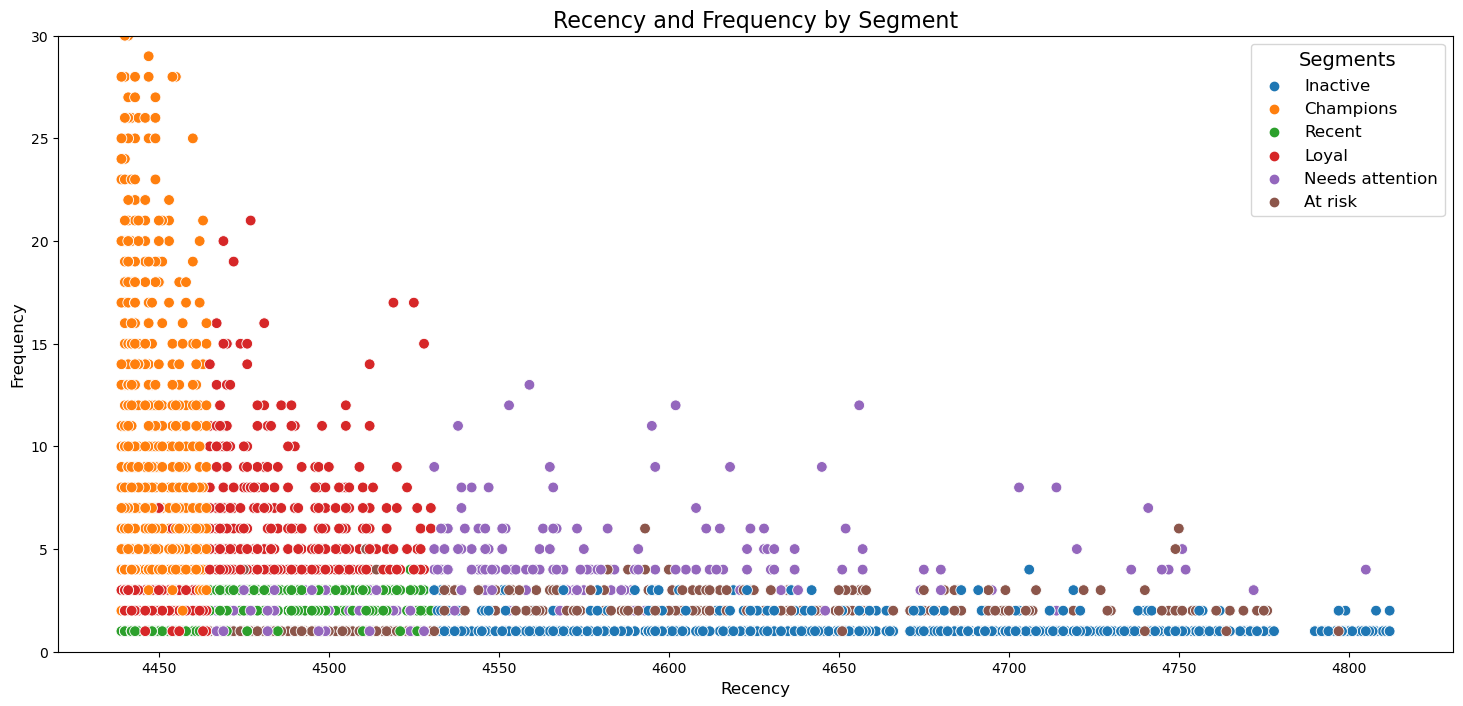

In [29]:
plt.figure(figsize=(18, 8))
sns.scatterplot(
    data=rfm, x="Recency", y="Frequency", hue="Segment", palette='tab10', s=60
)
plt.title("Recency and Frequency by Segment", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Frequency", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Segments", title_fontsize=14)
plt.ylim(0, 30)  #the axis needs limiting because of the high number of outliers
plt.show()

- Some 'At risk' and 'Inactive' customers are mixed together
- Some 'Recent', 'Needs attention' and 'At risk' customers are mixed together

### Recency and Monetary by Segment

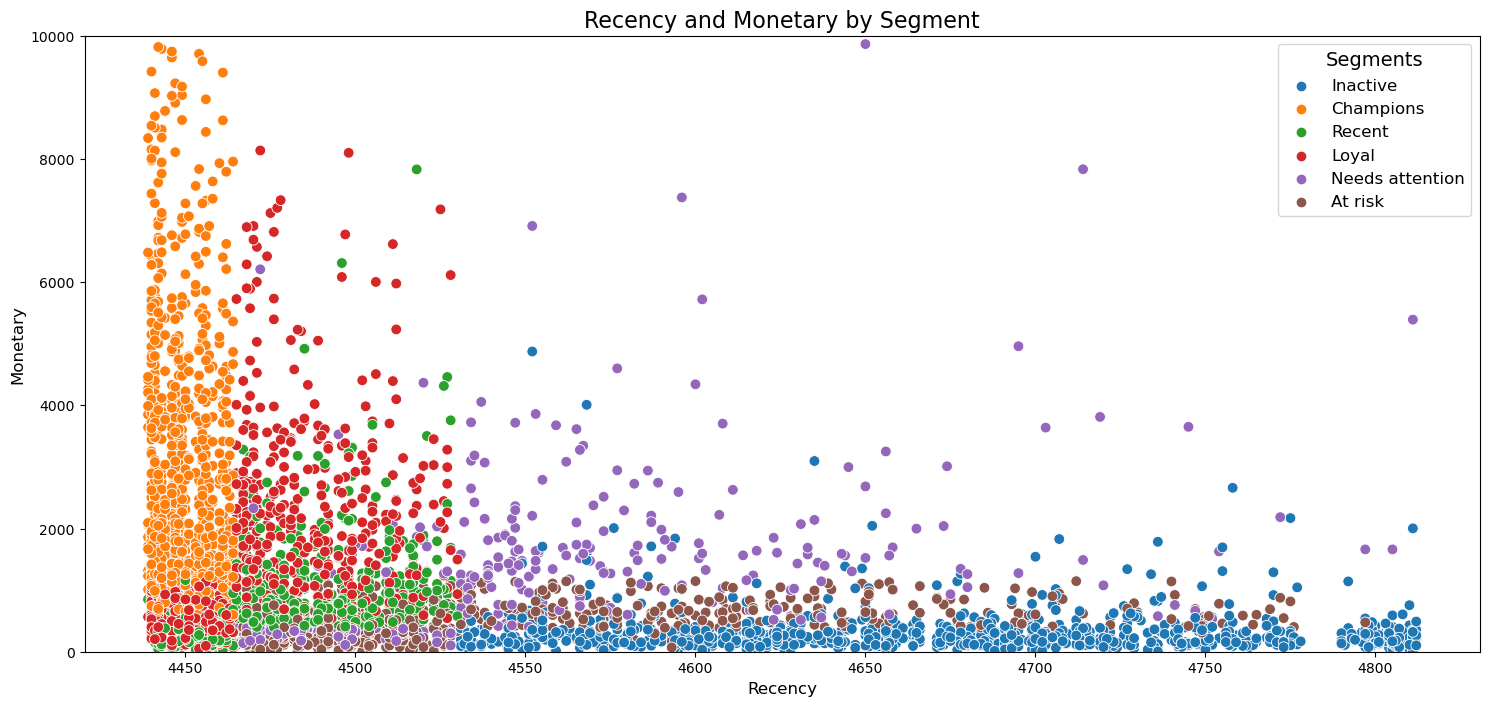

In [30]:
plt.figure(figsize=(18, 8))
sns.scatterplot(
    data=rfm, x="Recency", y="Monetary", hue="Segment", palette='tab10', s=60
)
plt.title("Recency and Monetary by Segment", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Monetary", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Segments", title_fontsize=14)
plt.ylim(0, 10000) # the axis needs limiting because of the high number of outliers
plt.show()

- Some 'At risk' and 'Inactive' customers are mixed together
- Some 'Recent', 'Needs attention' and 'At risk' customers are mixed together
Similar observations were on the Recency and Frequency scatter plot.

# K-Means Clustering
K-Means clustering is a very common unsupervised learning algorithm. It scales to very large datasets and tends to work well in practice. The K-Means clustering algorithm tries to find the best way of grouping data points into k different groups, where k is a parameter given to the algorithm.  
In this section I will use elbow method and silhouette score to determine the optimal number of clusters for Recency, Frequency and Monetary.  

## Log Transformation
Recency, Frequency and Monetary values have right-skewed distributions. K-means clustering works well with symmetric distribution of variables.

In [31]:
cols_for_clustering = ['Recency', 'Frequency', 'Monetary']
rfm_log = rfm.copy()
rfm_log[cols_for_clustering] = rfm[cols_for_clustering].apply(np.log1p)
rfm_log.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,8.418693,1.345582,6.588562
std,0.021777,0.683104,1.258438
min,8.398410,0.693147,1.558145
25%,8.402231,0.693147,5.728418
50%,8.409608,1.098612,6.506636
75%,8.429836,1.791759,7.415535
max,8.479076,5.347108,12.543284


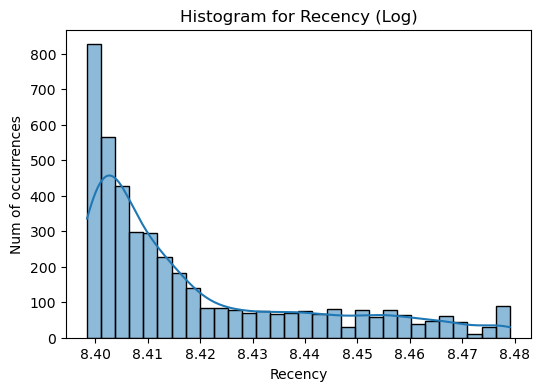

In [32]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=rfm_log, x='Recency', bins=30, kde=True)
plt.title('Histogram for Recency (Log)')
plt.xlabel('Recency')
plt.ylabel('Num of occurrences')
plt.show()

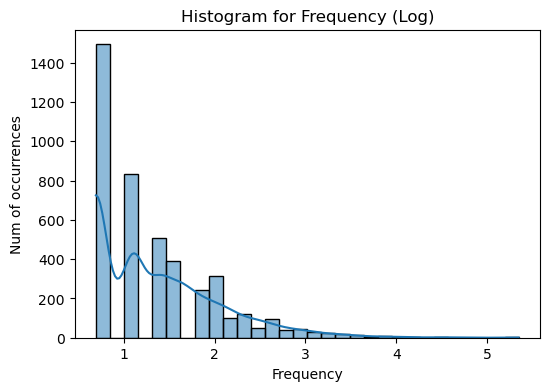

In [33]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=rfm_log, x='Frequency', bins=30, kde=True)
plt.title('Histogram for Frequency (Log)')
plt.xlabel('Frequency')
plt.ylabel('Num of occurrences')
plt.show()

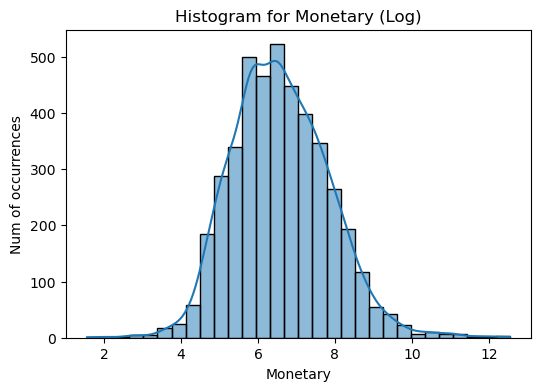

In [34]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=rfm_log, x='Monetary', bins=30, kde=True)
plt.title('Histogram for Monetary (Log)')
plt.xlabel('Monetary')
plt.ylabel('Num of occurrences')
plt.show()

## Standardising Data
K-Means clustering relies on distances between data points to assign them to clusters. If features have different scales, the algorithm may give more weight to features with larger scales, leading to biased cluster assignments. RobustScaler scales the data based on the interquartile range (IQR) to handle outliers. Recency, Frequency and Monetary features have many outliers therefore RobustScaler may be a good choice.

In [35]:
scaler = RobustScaler()
rfm_scaled = rfm_log.copy()
rfm_scaled[cols_for_clustering] = scaler.fit_transform(rfm_log[cols_for_clustering])
rfm_scaled[cols_for_clustering].describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4.338000e+03
mean,0.329091,0.224802,4.856011e-02
std,0.788893,0.621788,7.459105e-01
min,-0.405661,-0.369070,-2.933106e+00
25%,-0.267226,-0.369070,-4.612708e-01
50%,0.000000,0.000000,-2.632240e-16
75%,0.732774,0.630930,5.387292e-01
max,2.516485,3.867147,3.578086e+00


## Elbow Method

The elbow method is a technique that helps to determine the optimal number of clusters (K) for K-means clustering algorithm.

In [36]:
X = rfm_scaled[cols_for_clustering]
inertia_list = []
for K in range(2,10):
    inertia = KMeans(n_clusters=K, random_state=7).fit(X).inertia_
    inertia_list.append(inertia)    

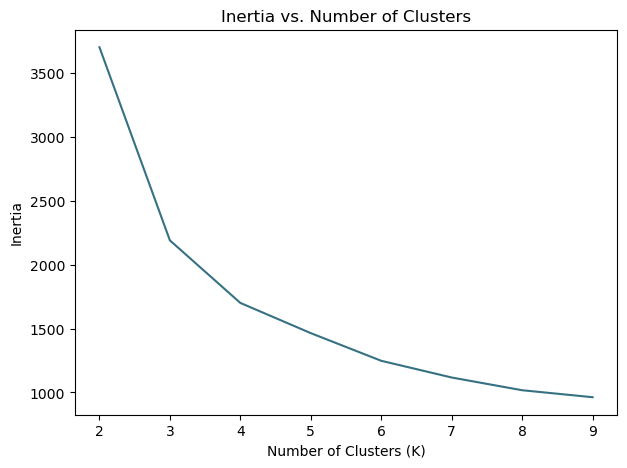

In [37]:
plt.figure(figsize=[7,5])
plt.plot(range(2,10), inertia_list, color=(54 / 255, 113 / 255, 130 / 255))
plt.title("Inertia vs. Number of Clusters")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.show()

There is no clear elbow on the chart. 3 or 4 clusters may be a good number of clusters.

## Silhouette Score  
Silhouette score is a metric that used to assess the quality of clustering. A higher silhouette score indicates that the clusters are well-separated, while a lower score suggests that the clusters may overlap or are poorly defined.

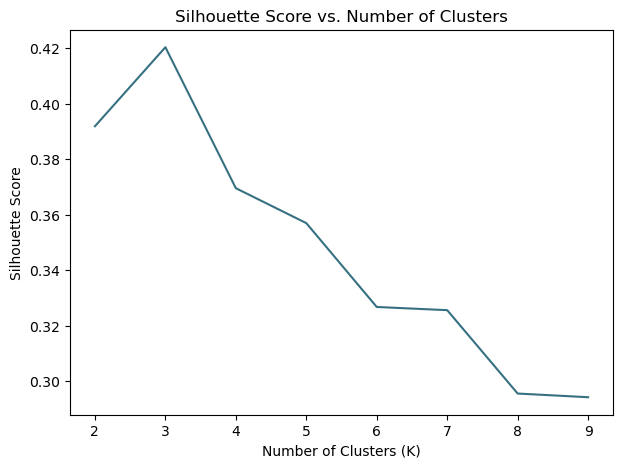

In [46]:
from sklearn.metrics import silhouette_score
silhouette_list = []
for K in range(2,10):
    model = KMeans(n_clusters = K, random_state=7)
    clusters = model.fit_predict(X)
    s_avg = silhouette_score(X, clusters)
    silhouette_list.append(s_avg)

plt.figure(figsize=[7,5])
plt.plot(range(2,10), silhouette_list, color=(54 / 255, 113 / 255, 130 / 255))
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

The highest Silhouette score is for 3 clusters. 3 clusters seem to be a good enough choice.

## Model with 3 Clusters

In [52]:
model = KMeans(n_clusters=3, random_state = 7)
model.fit(rfm_scaled[cols_for_clustering])
rfm_scaled['Cluster'] = model.predict(rfm_scaled[cols_for_clustering])
rfm['Cluster'] = rfm_scaled.Cluster

## Evaluating Clusters

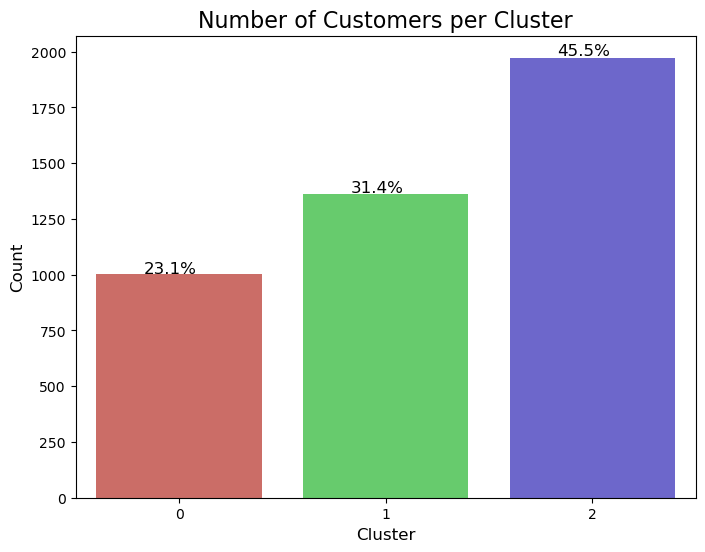

In [53]:
plt.figure(figsize = (8, 6))
ax = sns.countplot(data = rfm,
                   x = 'Cluster',
                   palette = 'hls')
total = len(rfm.Cluster)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 12)
plt.title('Number of Customers per Cluster', size = 16)
plt.xlabel('Cluster', size = 12)
plt.ylabel('Count', size = 12)
plt.show()

### Recency and Frequency by Cluster

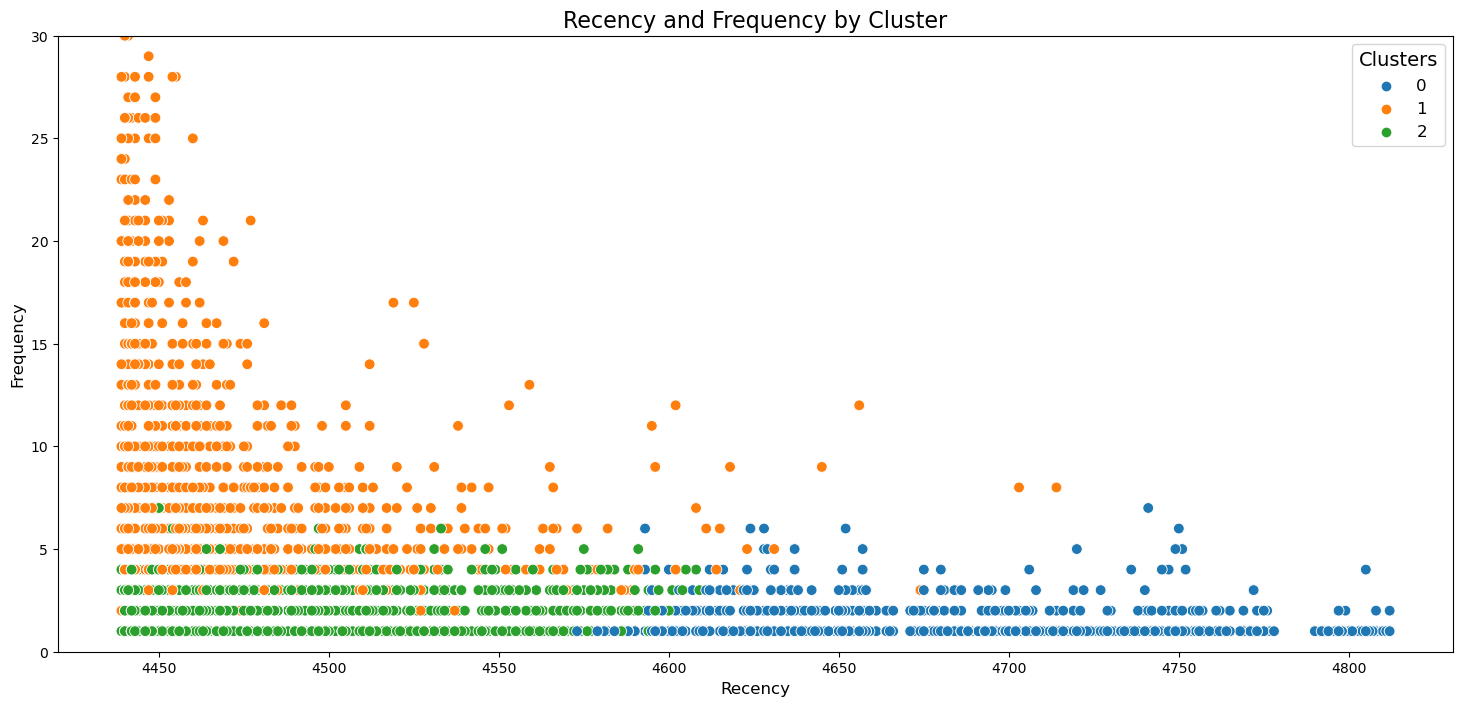

In [54]:
plt.figure(figsize=(18, 8))
sns.scatterplot(
    data=rfm, x="Recency", y="Frequency", hue="Cluster", palette='tab10', s=60
)
plt.title("Recency and Frequency by Cluster", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Frequency", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Clusters", title_fontsize=14)
plt.ylim(0, 30)  #the axis needs limiting because of the high number of outliers
plt.show()

### Recency and Monetary by Cluster

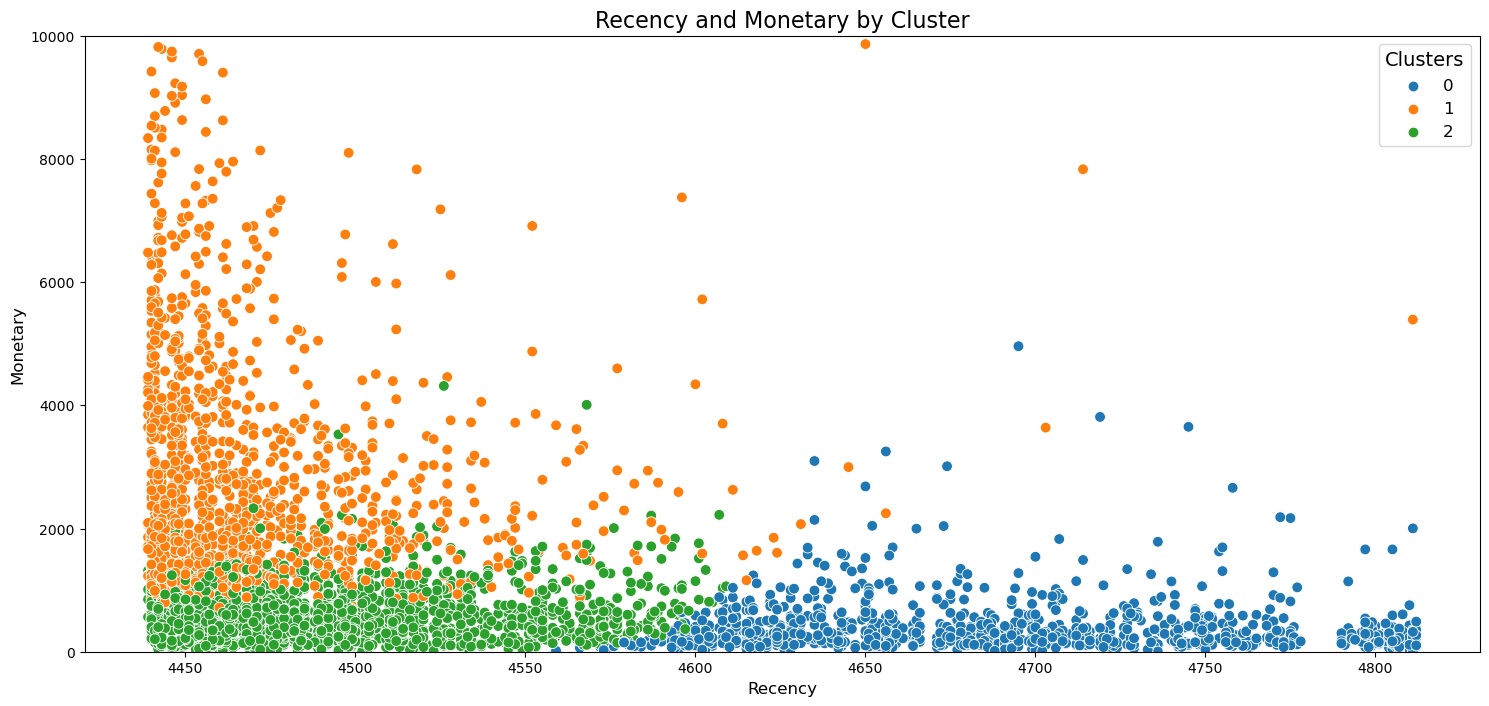

In [55]:
plt.figure(figsize=(18, 8))
sns.scatterplot(
    data=rfm, x="Recency", y="Monetary", hue="Cluster", palette='tab10', s=60
)
plt.title("Recency and Monetary by Cluster", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Monetary", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Clusters", title_fontsize=14)
plt.ylim(0, 10000) # the axis needs limiting because of the high number of outliers
plt.show()

# Comparing Results: RFM Segments vs. K-Mean Clusters
## Descriptive Statistics

In [56]:
rfm_stats_cl = rfm[['Recency','Frequency','Monetary','Cluster']].groupby('Cluster').agg({'mean','std','max','min'})

rfm_stats_cl

Recency                               Frequency                 \
            min   max         mean        std       min  max      mean   
Cluster                                                                  
0          4559  4812  4691.792622  64.784711         1    7  1.429711   
1          4439  4811  4469.078561  37.695838         1  209  9.616740   
2          4439  4609  4492.135327  39.693366         1    7  2.027369   

                   Monetary                                        
               std      min        max         mean           std  
Cluster                                                            
0         0.828506     3.75    4959.10   403.649453    435.479575  
1        12.036191   694.40  280206.02  5389.542107  15510.988440  
2         1.056354     6.20    4314.72   578.708638    410.049855

In [57]:
combined_stats = pd.concat([rfm_stats_cl.assign(Source='Cluster'), rfm_stats.assign(Source='Segment')])
combined_stats.head(20)

Recency                               Frequency       \
                    min   max         mean        std       min  max   
0                  4559  4812  4691.792622  64.784711         1    7   
1                  4439  4811  4469.078561  37.695838         1  209   
2                  4439  4609  4492.135327  39.693366         1    7   
At risk            4465  4797  4541.526316  73.130287         1    6   
Champions          4439  4464  4449.181250   7.439885         2  209   
Inactive           4531  4812  4674.309035  79.987216         1    4   
Loyal              4439  4530  4471.061697  22.433228         1   63   
Needs attention    4465  4811  4554.874251  70.417304         1   34   
Recent             4439  4530  4480.879457  23.791914         1    4   

                                      Monetary                          \
                      mean        std      min        max         mean   
0                 1.429711   0.828506     3.75    4959.10   403.649453   
1                 9.616740  12.036191   694.40  280206.02  5389.542107   
2                 2.027369   1.056354     6.20    4314.72   578.708638   
At risk           1.547653   0.816631     6.20    1149.02   467.986132   
Champions        10.706250  13.920943   400.86  280206.02  5998.648469   
Inactive          1.163244   0.436095     3.75   77183.60   397.662012   
Loyal             4.703085   3.614359    49.80   80850.84  1743.005040   
Needs attention   3.461078   2.636652     6.90   44534.30  1599.673566   
Recent            2.067912   0.866304    30.00   12601.83   885.976946   

                                Source  
                          std           
0                  435.479575  Cluster  
1                15510.988440  Cluster  
2                  410.049855  Cluster  
At risk            278.915871  Segment  
Champions        17978.933169  Segment  
Inactive          2487.674255  Segment  
Loyal             3433.932571  Segment  
Needs attention   3459.751153  Segment  
Recent            1014.815794  Segment

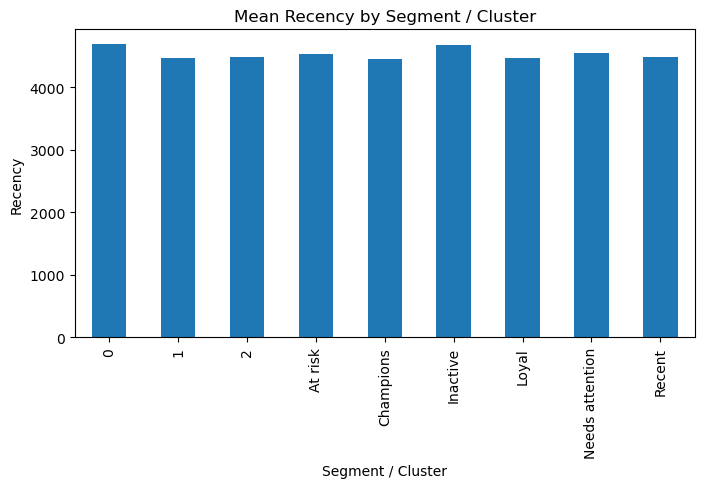

In [58]:
combined_stats[('Recency', 'mean')].plot(kind='bar', figsize=(8, 4))
plt.title('Mean Recency by Segment / Cluster')
plt.xlabel('Segment / Cluster')
plt.ylabel('Recency')
plt.show()

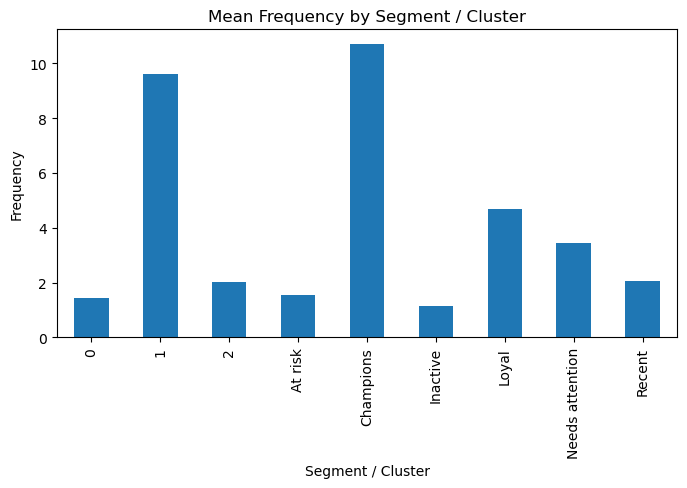

In [59]:
combined_stats[('Frequency', 'mean')].plot(kind='bar', figsize=(8, 4))
plt.title('Mean Frequency by Segment / Cluster')
plt.xlabel('Segment / Cluster')
plt.ylabel('Frequency')
plt.show()

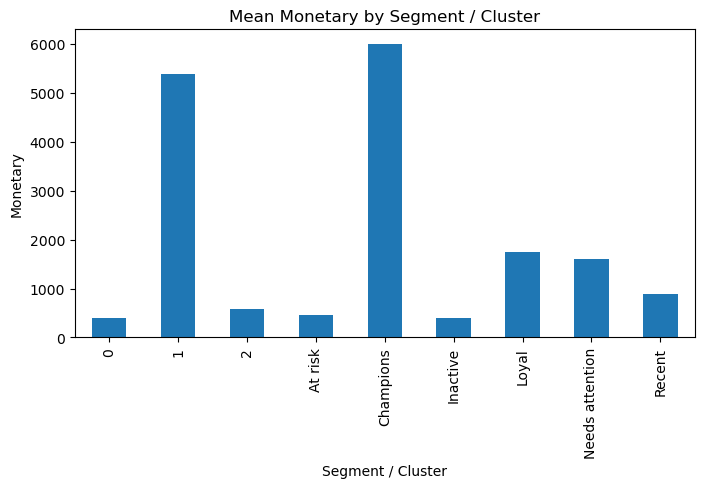

In [60]:
combined_stats[('Monetary', 'mean')].plot(kind='bar', figsize=(8, 4))
plt.title('Mean Monetary by Segment / Cluster')
plt.xlabel('Segment / Cluster')
plt.ylabel('Monetary')
plt.show()

## Mapping of Clusters and RFM Segments

In [61]:
rfm_cl_seg = rfm[['Cluster', 'Segment', 'CustomerID']].groupby(['Cluster', 'Segment']).agg({'count'})
rfm_cl_seg=rfm_cl_seg.reset_index()
rfm_cl_seg.head()

,Cluster,Segment,CustomerID
,,,count
0,0,At risk,142
1,0,Inactive,810
2,0,Needs attention,51
3,1,Champions,848
4,1,Inactive,2


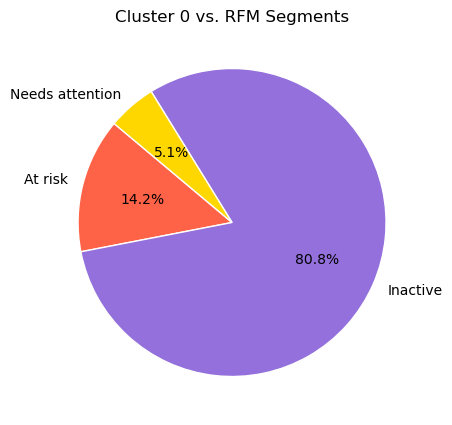

In [62]:
color_mapping = {
    'Champions':'forestgreen',
    'Loyal' : 'lightseagreen',
    'Recent' : 'deepskyblue',
    'Needs attention': 'gold',
    'At risk': 'tomato',
    'Inactive': 'mediumpurple'
    }

rfm_cluster = rfm_cl_seg[rfm_cl_seg[('Cluster', )] == 0]
plt.figure(figsize=(5, 5))
colors = sns.color_palette('hls')
plt.pie(rfm_cluster[('CustomerID', 'count')], 
        labels=rfm_cluster[('Segment', )], 
        autopct='%1.1f%%', startangle=140, 
        colors=rfm_cluster['Segment'].map(color_mapping), 
        wedgeprops=dict(edgecolor='white'))
plt.title('Cluster 0 vs. RFM Segments')
plt.show()

Cluster 0 contains mainly Loyal and Recent customers. These customers purchased recently however their mean Monetary value was low. This cluster contains 'promising' customers.

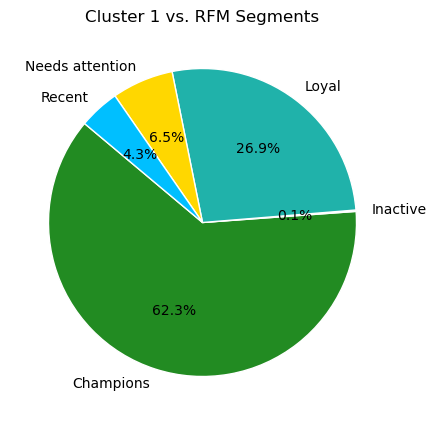

In [63]:
rfm_cluster = rfm_cl_seg[rfm_cl_seg[('Cluster', )] == 1]
plt.figure(figsize=(5, 5))
plt.pie(rfm_cluster[('CustomerID', 'count')], 
        labels=rfm_cluster[('Segment', )], 
        autopct='%1.1f%%', startangle=140, 
        colors=rfm_cluster['Segment'].map(color_mapping), 
        wedgeprops=dict(edgecolor='white'))
plt.title('Cluster 1 vs. RFM Segments')
plt.show()

Cluster 1 has mostly Inactive and At Risk customers as per the RFM Framework.

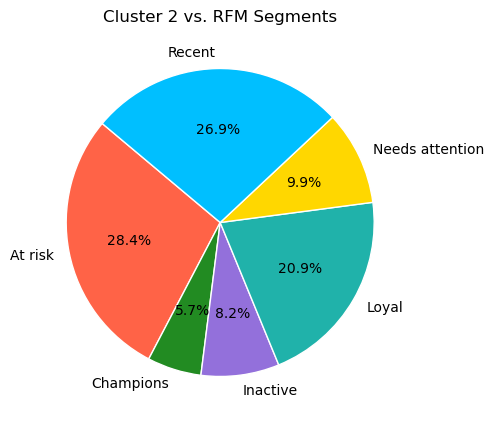

In [64]:
rfm_cluster = rfm_cl_seg[rfm_cl_seg[('Cluster', )] == 2]
plt.figure(figsize=(5, 5))
plt.pie(rfm_cluster[('CustomerID', 'count')], 
        labels=rfm_cluster[('Segment', )], 
        autopct='%1.1f%%', startangle=140, 
        colors=rfm_cluster['Segment'].map(color_mapping), 
        wedgeprops=dict(edgecolor='white'))
plt.title('Cluster 2 vs. RFM Segments')
plt.show()

Cluster 2 almost matches the Segment with Champions. 

# Conclusion

RFM Segments are easy to interpret and provide recommendations for marketing strategies tailored to each customer segment. However, some segments are not as distinct as those created by K-means clustering.

K-Means clustering generates very distinct segments that may require interpretation.

Interestingly, the Champions segment almost matched in both methods.

 
